In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import sklearn
import cv2
import os

In [25]:
blurred_folder = "/Users/bleaf/Desktop/Job/Blur/fin_dataset_last/blur/train"
not_blurred_folder = "/Users/bleaf/Desktop/Job/Blur/fin_dataset_last/clear/train"
output_csv_path = "results.csv"

In [26]:
data = [{'path': os.path.join(blurred_folder, img), 'label': 1} for img in os.listdir(blurred_folder)]
data.extend([{'path': os.path.join(not_blurred_folder, img), 'label': 0} for img in os.listdir(not_blurred_folder)])


In [27]:
df = pd.DataFrame(data)
df

,path,label
0,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,1
1,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,1
2,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,1
3,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,1
4,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,1
...,...,...
2731,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,0
2732,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,0
2733,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,0
2734,/Users/bleaf/Desktop/Job/Blur/fin_dataset_last...,0


In [28]:
def laplacian_variance(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def gradient_magnitude(image):
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    return np.mean(gradient_magnitude)

def frequency_based(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return np.mean(magnitude_spectrum)

def edge_based(image):
    edges = cv2.Canny(image, 50, 150)
    return np.sum(edges) / float(image.size)

In [71]:
lap = []
grad = []
freq = []
e_based = []
for img in df['path']:
	bwimg = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
	bwimg = cv2.resize(bwimg, (640, 480))
	lap.append(laplacian_variance(bwimg))
	grad.append(gradient_magnitude(bwimg))
	freq.append(frequency_based(bwimg))
	e_based.append(edge_based(bwimg))

df['laplacian'] = lap
df['gradient_magnitude'] = grad
df['frequency_based'] = freq
df['edge_based'] = e_based

<Axes: >

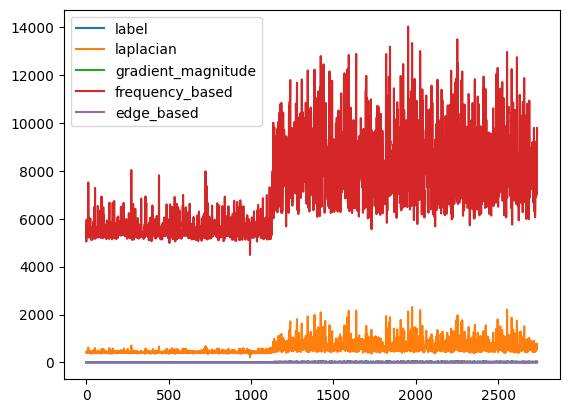

In [30]:
df.plot()

<Axes: >

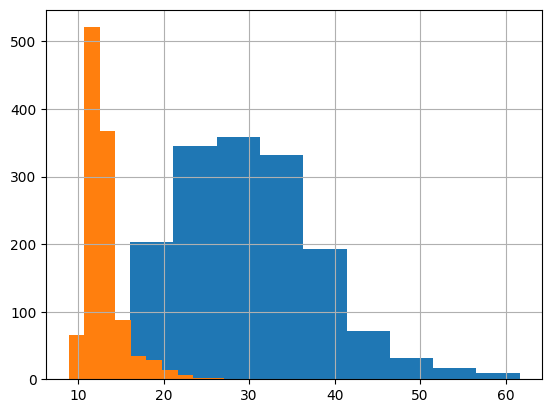

In [72]:
df[df['label'] == 0]['gradient_magnitude'].hist()
df[df['label'] == 1]['gradient_magnitude'].hist()


<Axes: >

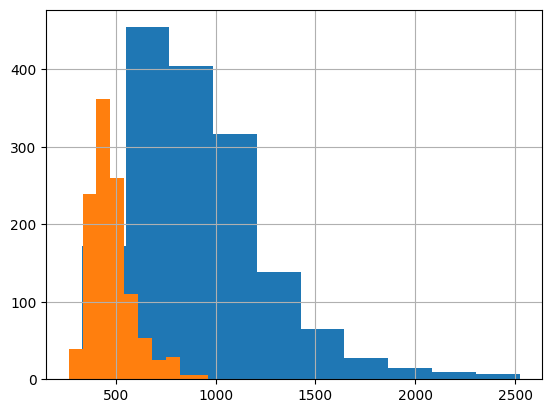

In [73]:
df[df['label'] == 0]['laplacian'].hist()
df[df['label'] == 1]['laplacian'].hist()

<Axes: >

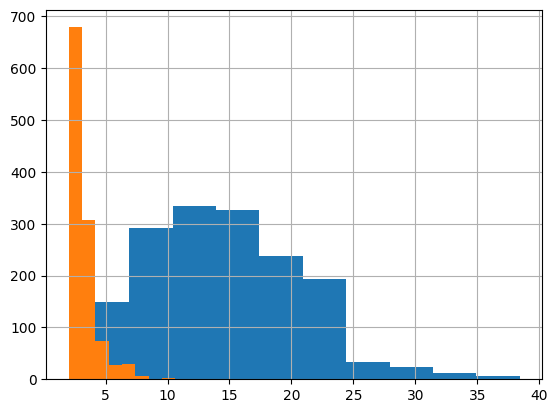

In [74]:
df[df['label'] == 0]['edge_based'].hist(grid=True)

df[df['label'] == 1]['edge_based'].hist(grid=True)

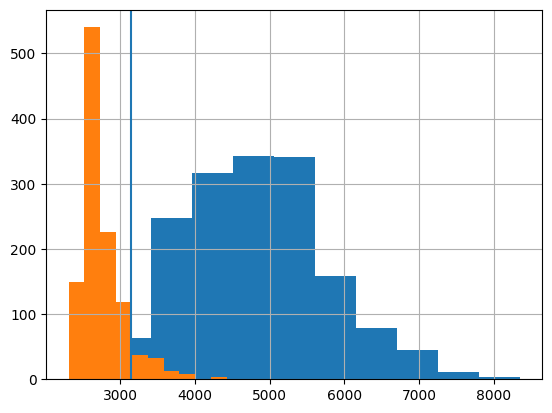

In [79]:
df[df['label'] == 0]['frequency_based'].hist()
df[df['label'] == 1]['frequency_based'].hist()
plt.axvline(3150)

In [98]:
heights = []
widths = []
for img in df['path']:
# 	bwimg = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
# 	h, w = bwimg.shape
	heights.append(640)
	widths.append(480)
df['height'] = heights
df['widths'] = widths


In [99]:
df.to_csv('analyze.csv')

In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
scaler = StandardScaler()

In [102]:
scaler.fit(df.drop(['label', 'path'], axis=1))
scaled_features = scaler.transform(df.drop(['label', 'path'], axis=1))

In [104]:
scaled_data = pd.DataFrame(scaled_features, columns = df.drop(['label', 'path'], axis=1).columns)
scaled_data


,laplacian,gradient_magnitude,frequency_based,edge_based,height,widths
0,-0.666824,-0.782283,-0.805932,-0.841685,0.0,0.0
1,-1.006501,-1.215219,-1.310278,-1.009354,0.0,0.0
2,-0.723646,-0.621682,-0.718774,-0.839416,0.0,0.0
3,-0.666595,-0.778733,-0.709043,-0.828866,0.0,0.0
4,-0.604673,-1.038248,-1.042362,-1.002548,0.0,0.0
...,...,...,...,...,...,...
2731,0.592552,0.903932,0.658493,0.926558,0.0,0.0
2732,-0.201837,-0.063675,-0.036578,-0.262329,0.0,0.0
2733,1.156630,1.470885,1.205783,1.705233,0.0,0.0
2734,0.846410,1.052033,0.791300,1.000750,0.0,0.0


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

x = scaled_data
y = df['label']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)

In [115]:
model = KNeighborsClassifier(n_neighbors = 5)

model.fit(x_training_data, y_training_data)

KNeighborsClassifier()

In [116]:
predictions = model.predict(x_test_data)
print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       477
           1       0.97      0.95      0.96       344

    accuracy                           0.97       821
   macro avg       0.97      0.96      0.97       821
weighted avg       0.97      0.97      0.97       821



In [117]:
print(confusion_matrix(y_test_data, predictions))

[[468   9]
 [ 18 326]]


In [118]:
error_rates = []

In [119]:
for i in np.arange(1, 101):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))


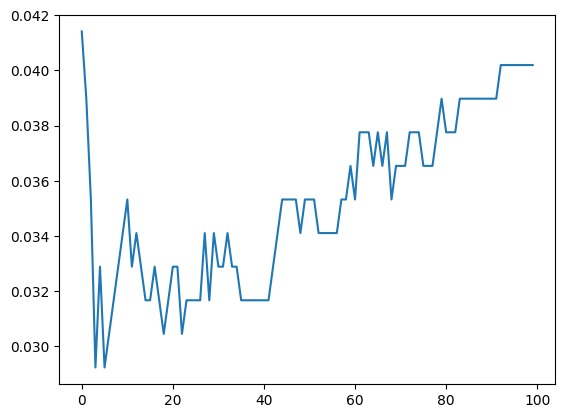

In [120]:
plt.plot(error_rates)

In [121]:
import time
times = []
for i, img in enumerate(df['path']):
	# if i == 1000:
	# 	break
	bwimg = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
	start = time.time()
	lap.append(laplacian_variance(bwimg))
	grad.append(gradient_magnitude(bwimg))
	freq.append(frequency_based(bwimg))
	e_based.append(edge_based(bwimg))
	end = time.time()
	times.append(end - start)

print(f"Mean time: {sum(times)/len(times)}")


KeyboardInterrupt: 